## Project Introduction:
# Sentiment Analysis of Amazon Reviews 
#### Capstone project BrainStation - Edo Spigel Emmerich
I will lay out the aims of this capstone project:
1. *How can we use machine learning to better understand the sentiment of reviews?*
2. *How can we use machine learning to understand common user complaints about products?*

By utilising machine learning techniques, I hope to be able to build a system which identifies key factors leading to either a positive or negative review. Due to the class imbalance favoring positive reviews, which is discussed later, it will particularly be interesting to try understand in which ways different models can interpret different types of negative reviews. Being able to extract and track common and new issues surrounding a product is an invaluable tool to a business and can act as a first line of service when identifying customer painpoints. 

I will try and create a system which allows the user to utilise different models in order to uncover the key reasons behind the rating of reviews. This should work both on an individual textual input (1 review), as well as on a larger set of reviews.

There are many services available to perform Sentiment Analysis for businesses, such as [Amazon Comprehend](https://aws.amazon.com/comprehend/) and [Google Cloud Natural Language](https://cloud.google.com/natural-language/docs/analyzing-sentiment), however these solutions are often costly, and being able to perform this analysis *inhouse* is more cost-efficent, as well as giving the business user much more control. 

#### The data:
The data was collated by:\
Justifying recommendations using distantly-labeled reviews and fined-grained aspects\
*Jianmo Ni, Jiacheng Li, Julian McAuley University of California, San Diego*\
Empirical Methods in Natural Language Processing (EMNLP), 2019\
[pdf](https://cseweb.ucsd.edu/~jmcauley/pdfs/emnlp19a.pdf)

I am using the [2018 edition](https://cseweb.ucsd.edu/~jmcauley/datasets/amazon_v2/). In total there are 233.1 million reviews. However they provide what they call *5-core* reviews: *These data have been coraluced to extract the [5]-core, such that each of the remaining users and items have [5] reviews each.* These extracts are designed for projects such as this. I settled on the *Cell Phones and Accessories* dataset, which has 1,128,437 reviews in total. I chose this category over categories such as *Movies and TV,  Books* or *CDs and Vinyl*, as barring some product issues, the majority of reviews regard the content of these products, and this isn't a movie review analysis project! In contrast, the *Cell Phones and Accessories* reviews contain information directly about the product, which is much more useful to us. I would have liked to be able to have a more balanced dataset, but it seems the nature of these 5-core datasets is that the reviews are much more positive than they are negative. In future, I would like to try this approach on different data and see the key differences. 

Using the data is easy, as the providers have notebooks giving functions for reading in. As one might expect, the reviews contain many spelling mistakes. This is something that the approach i have taken will not take into account unless there is a very common misspelling of a word. Word embeddings may help with this issue.





# EDA

**Objective**: This notebook explores the content of the Amazon customer reviews dataset. I will also clean the data and prepare it for preprocessing. The goal is to understand the sentiment or other characteristics of the reviews that could be beneficial for business insights. I will look at the data available first, and then import the document-term matrix from the vectorisation stage to better understand some of the trends in the reviews. 


**Key Findings**: 
- Bimodal distribution of review lengths
- Over 48,000 unique products

Lets read in the data:


In [1]:
import pandas as pd
import numpy as np
import gzip
import json
import matplotlib.pyplot as plt
import seaborn as sns
from source import getDF, rating_distribution, simplifyReviews
import joblib
%config InlineBackend.figure_format="retina"
from sklearn.feature_extraction.text import CountVectorizer
from source import my_tokenizer


In [2]:
df = getDF('../data/Cell_Phones_and_Accessories_5.json.gz')

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1128437 entries, 0 to 1128436
Data columns (total 12 columns):
 #   Column          Non-Null Count    Dtype  
---  ------          --------------    -----  
 0   overall         1128437 non-null  float64
 1   verified        1128437 non-null  bool   
 2   reviewTime      1128437 non-null  object 
 3   reviewerID      1128437 non-null  object 
 4   asin            1128437 non-null  object 
 5   style           605241 non-null   object 
 6   reviewerName    1128302 non-null  object 
 7   reviewText      1127672 non-null  object 
 8   summary         1127920 non-null  object 
 9   unixReviewTime  1128437 non-null  int64  
 10  vote            92034 non-null    object 
 11  image           27107 non-null    object 
dtypes: bool(1), float64(1), int64(1), object(9)
memory usage: 104.4+ MB


We see that we have 12 columns in total. We have the star review, whether the review is verified, the review time, ID of reviewer, some keys to link to the product data, the name of the reviewer, the actual text review, the summary review as well as whether their review was marked as helpful, and some images of the product. 

## Data Dictionary

| Column name    | Datatype | Measures| Notes|
| -------------- | -------- | ---------------------------------------------------- | --------------------------------------- |
| overall        | float    | Overall star rating of review   |                                         |
| verified       | boolean  | Whether the review has been verified as real or not. | |
| reviewTime     | object   | Time of review    | If needed can change type to datetime64 |
| reviewerID     | object   | Unique ID of reviewer                                |                                         |
| asin           | object   | Product metadata  |Amazon Standard Identification Number|
| style          | object   | Product metadata                                     |                                         |
| reviewerName   | object   | Name of reviewer                                     |                                         |
| reviewText     | object   | Textual contents of review                           |                                         |
| summary        | object   | Textual summary of review                            |                                         |
| unixReviewTime | int64    | Time of review since Unix Epoch on January 1st, 1970 |                                         |
| vote           | object   | Count of usefulness vote                             |                                         |
| image          | object   | Image of product reviewed                            |                                         |

#### Data cleaning:
removing null and duplicate values. 
As we see later, there are reviews which become duplicate in the vectorisation stage, but they are not duplicate raw reviews.


In [4]:
# checking for null values, rows with no reviews are not useful 
df.isna().sum()

overall                 0
verified                0
reviewTime              0
reviewerID              0
asin                    0
style              523196
reviewerName          135
reviewText            765
summary               517
unixReviewTime          0
vote              1036403
image             1101330
dtype: int64

In [5]:
(df.isna().sum())/(df.shape[0])

overall           0.000000
verified          0.000000
reviewTime        0.000000
reviewerID        0.000000
asin              0.000000
style             0.463647
reviewerName      0.000120
reviewText        0.000678
summary           0.000458
unixReviewTime    0.000000
vote              0.918441
image             0.975978
dtype: float64

We see that we have nulls for some reviews as well as other metadata. These will not be helpful for sentiment analysis, but we will keep the "asin" so that we know what product the review is on.

In [6]:
df[['overall']].value_counts(normalize=True)

overall
5.0        0.626564
4.0        0.163439
3.0        0.087071
1.0        0.072258
2.0        0.050667
Name: proportion, dtype: float64

In [7]:
df[['overall']].value_counts().to_csv("../data/dist.csv")

we only want verified reviews, from the [Amazon](https://www.amazon.com/gp/help/customer/display.html?nodeId=G75XTB7MBMBTXP6W) website:

"After someone submits a review, we check if they:
Bought or used the item on Amazon;
Paid a price available to most Amazon shoppers.
If we confirm both, we label the review as Verified Purchase."

In [8]:
df['verified'].value_counts(normalize=True)

verified
True     0.874948
False    0.125052
Name: proportion, dtype: float64

In [9]:
reviewer_ID_df = df["reviewerID"]
len(reviewer_ID_df.unique())

157212

we only want verified reviews:

"After someone submits a review, we check if they:

Bought or used the item on Amazon;
Paid a price available to most Amazon shoppers.
If we confirm both, we label the review as Verified Purchase."
Lets make a simplified version of our data containing only rating and text review and also the product identifier (asin), including only the verified reviews containing textual data, first, lets drop duplicates based on reviewText and reviewerID

In [10]:
df.duplicated(subset=["reviewText","reviewerID" ]).sum()

107142

In [11]:
df = df.drop_duplicates(subset=["reviewText","reviewerID" ])

In [12]:
new_df = simplifyReviews(df)

<class 'pandas.core.frame.DataFrame'>
Index: 889148 entries, 0 to 1128436
Data columns (total 3 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   overall     889148 non-null  float64
 1   reviewText  888832 non-null  object 
 2   asin        889148 non-null  object 
dtypes: float64(1), object(2)
memory usage: 27.1+ MB


In [13]:
new_df.dropna(inplace=True)

In [14]:
new_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 886240 entries, 0 to 886239
Data columns (total 3 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   overall     886240 non-null  float64
 1   reviewText  886240 non-null  object 
 2   asin        886240 non-null  object 
dtypes: float64(1), object(2)
memory usage: 20.3+ MB


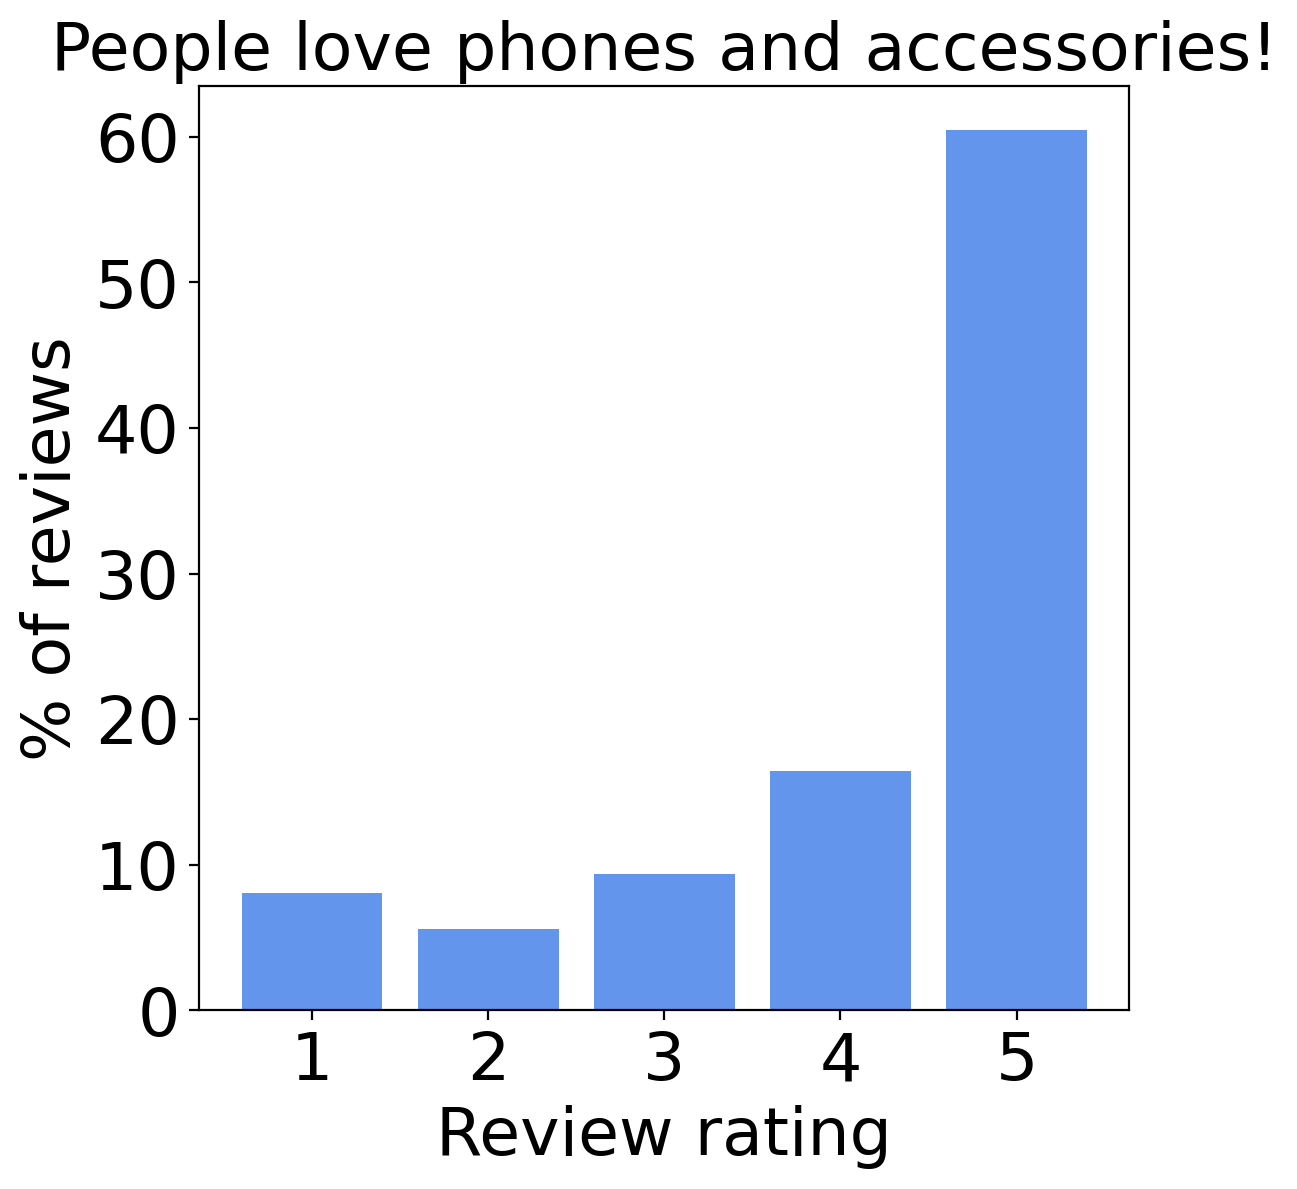

In [15]:
values, counts = np.unique(new_df['overall'], return_counts=True)
normalized_counts = counts/counts.sum()

plt.figure(figsize=(6,6))
bars = plt.bar(values, normalized_counts * 100, color="cornflowerblue")


plt.xlabel("Review rating", fontsize=24)
plt.ylabel('% of reviews', fontsize=24)
plt.title("People love phones and accessories!", fontsize=24)
plt.xticks(fontsize=24)
plt.yticks(fontsize=24)
plt.show()

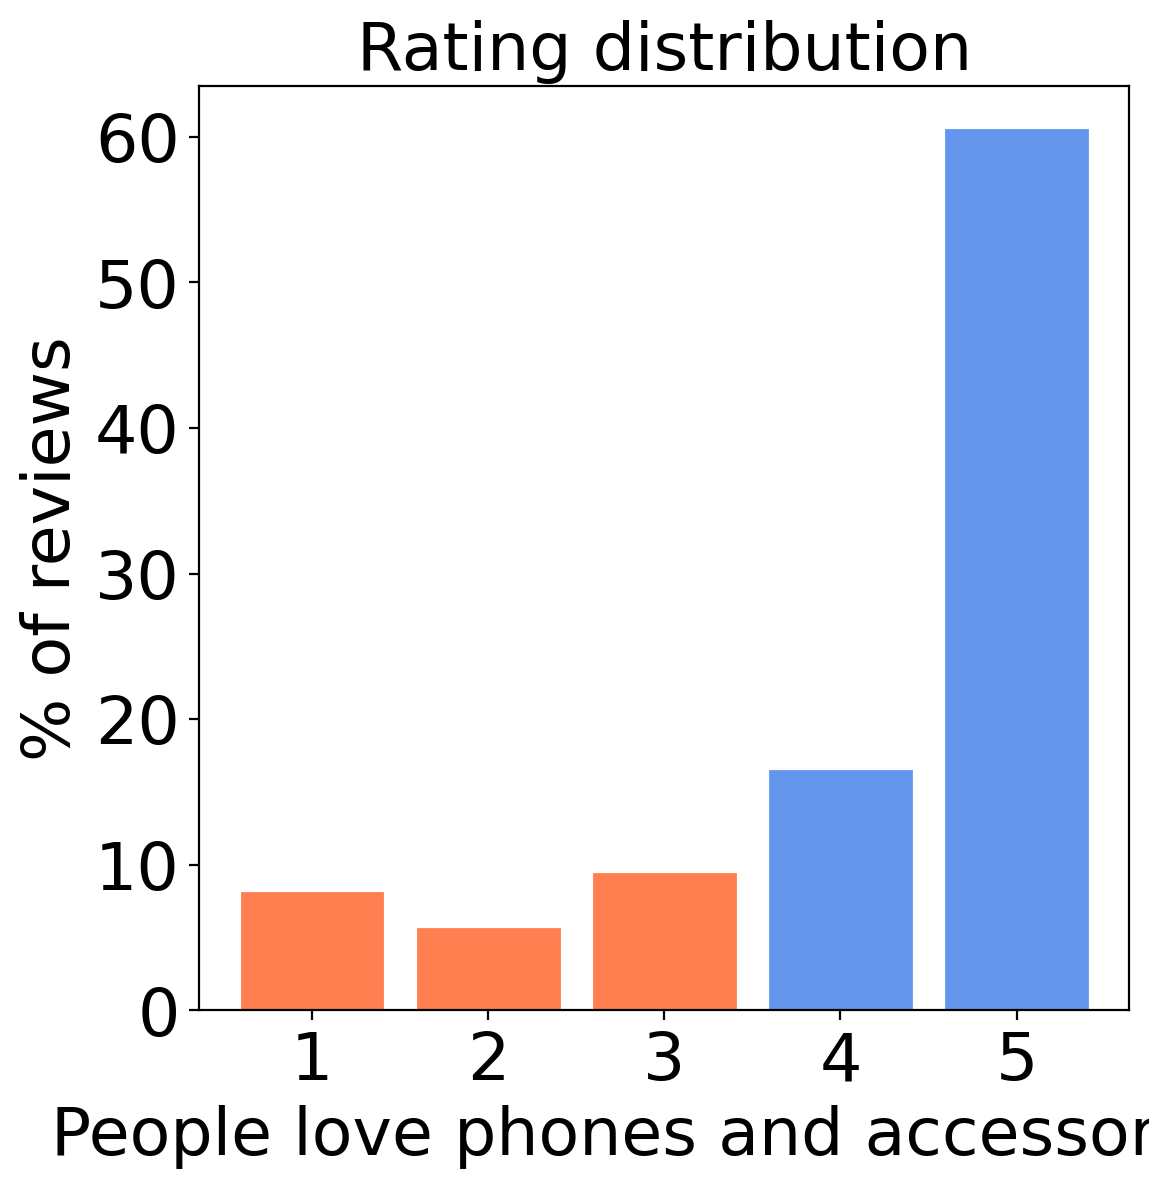

In [16]:
values, counts = np.unique(new_df['overall'], return_counts=True)
normalized_counts = counts/counts.sum()

plt.figure(figsize=(6,6))
bars = plt.bar(values, normalized_counts * 100)
bars[0].set_color('coral')
bars[1].set_color('coral')
bars[2].set_color('coral')
bars[3].set_color("cornflowerblue")
bars[4].set_color("cornflowerblue")

plt.xlabel("People love phones and accessories!", fontsize=24)
plt.ylabel('% of reviews', fontsize=24)
plt.title("Rating distribution", fontsize=24)
plt.xticks(fontsize=24)
plt.yticks(fontsize=24)

plt.show()

In [17]:
split = np.where(new_df["overall"]>3, 1, 0)
split_ser = pd.Series(split, index = new_df.index)
split_ser.value_counts(normalize=True)

1    0.769007
0    0.230993
Name: proportion, dtype: float64

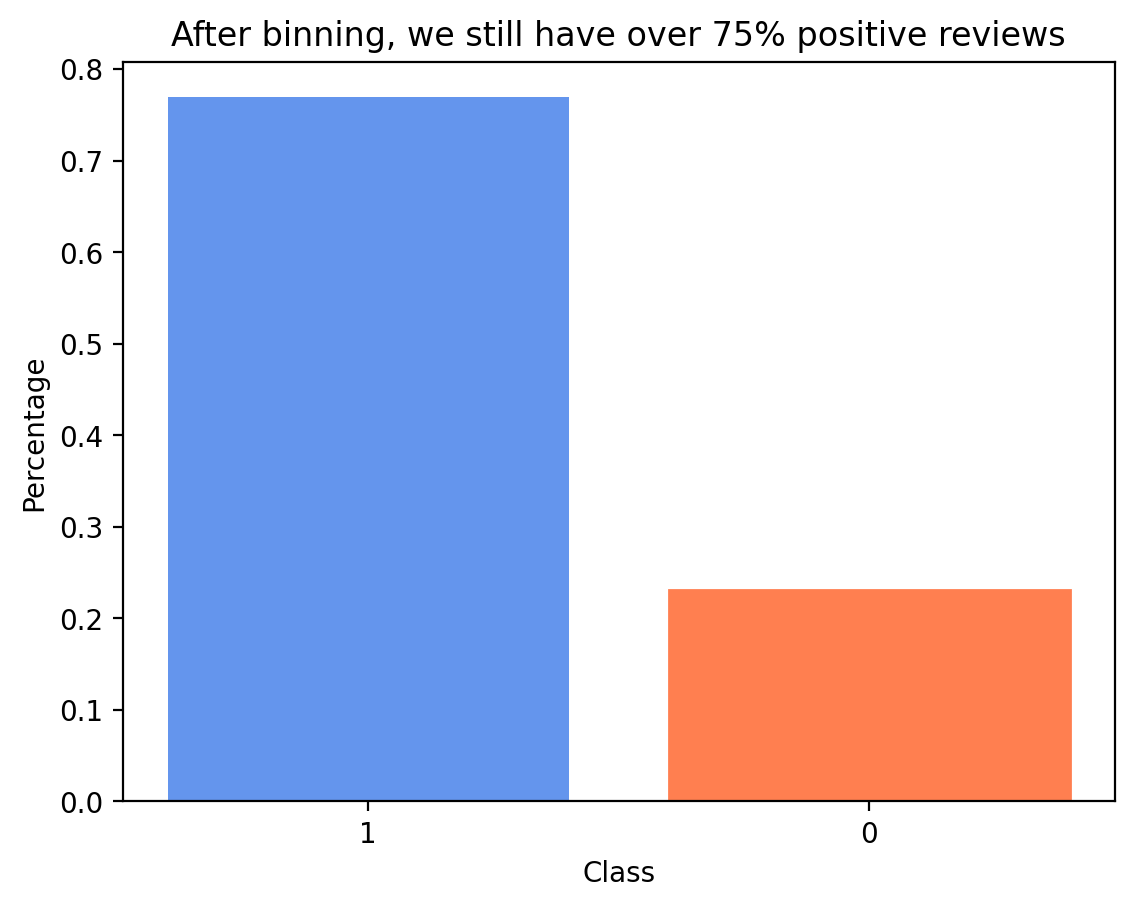

In [18]:
bars = plt.bar(x=["1","0"], height = split_ser.value_counts(normalize=True), color="cornflowerblue")
bars[1].set_color("coral")
plt.title("After binning, we still have over 75% positive reviews")
plt.xlabel("Class")
plt.ylabel("Percentage")
plt.show()

We see that the distribution of reviews is heavily skewed toward the 5 star category. This is the case with most categories of reviews on amazon, demonstrated in "01-first_explore.ipynb". This goes against what I expected: that people would be more polarised: a large amount of negative reviews (1 star) and a large amount of positive reviews (5 star), however over 62% of reviews are 5 star. I will downsample the majoirity class and compare the modelling on both balanced and unbalanced data. I did try SMOTE, however it negitively impacted the results (see archive). I will also group 1, 2 and 3 star reviews as "negative" and 4 and 5 star reviews as "positive", to turn this into a binary classification task. Whilst this increases the total in the negative class, it makes the positive class over 75% of the data which is not ideal. This is an issue I would like to explore in more detail later.

It will be useful to know the length of a review:

In [19]:
rev_len = list()
for review in new_df["reviewText"]:
    rev_len.append(len(review))

In [20]:
new_df["length"] = rev_len

In [21]:
new_df["length"].describe()

count    886240.000000
mean        225.216473
std         373.290243
min           1.000000
25%          45.000000
50%         120.000000
75%         258.000000
max       33457.000000
Name: length, dtype: float64

In [22]:
new_df.to_parquet("../data/clean_FINALREVIEWS.parquet")

We see that most reviews are between 34 and 240 characters long with a max of 33,457. We will probably not be able to analyse full essays but it will be useful before eliminating any to see if there is a relationship between review length and overall star rating.

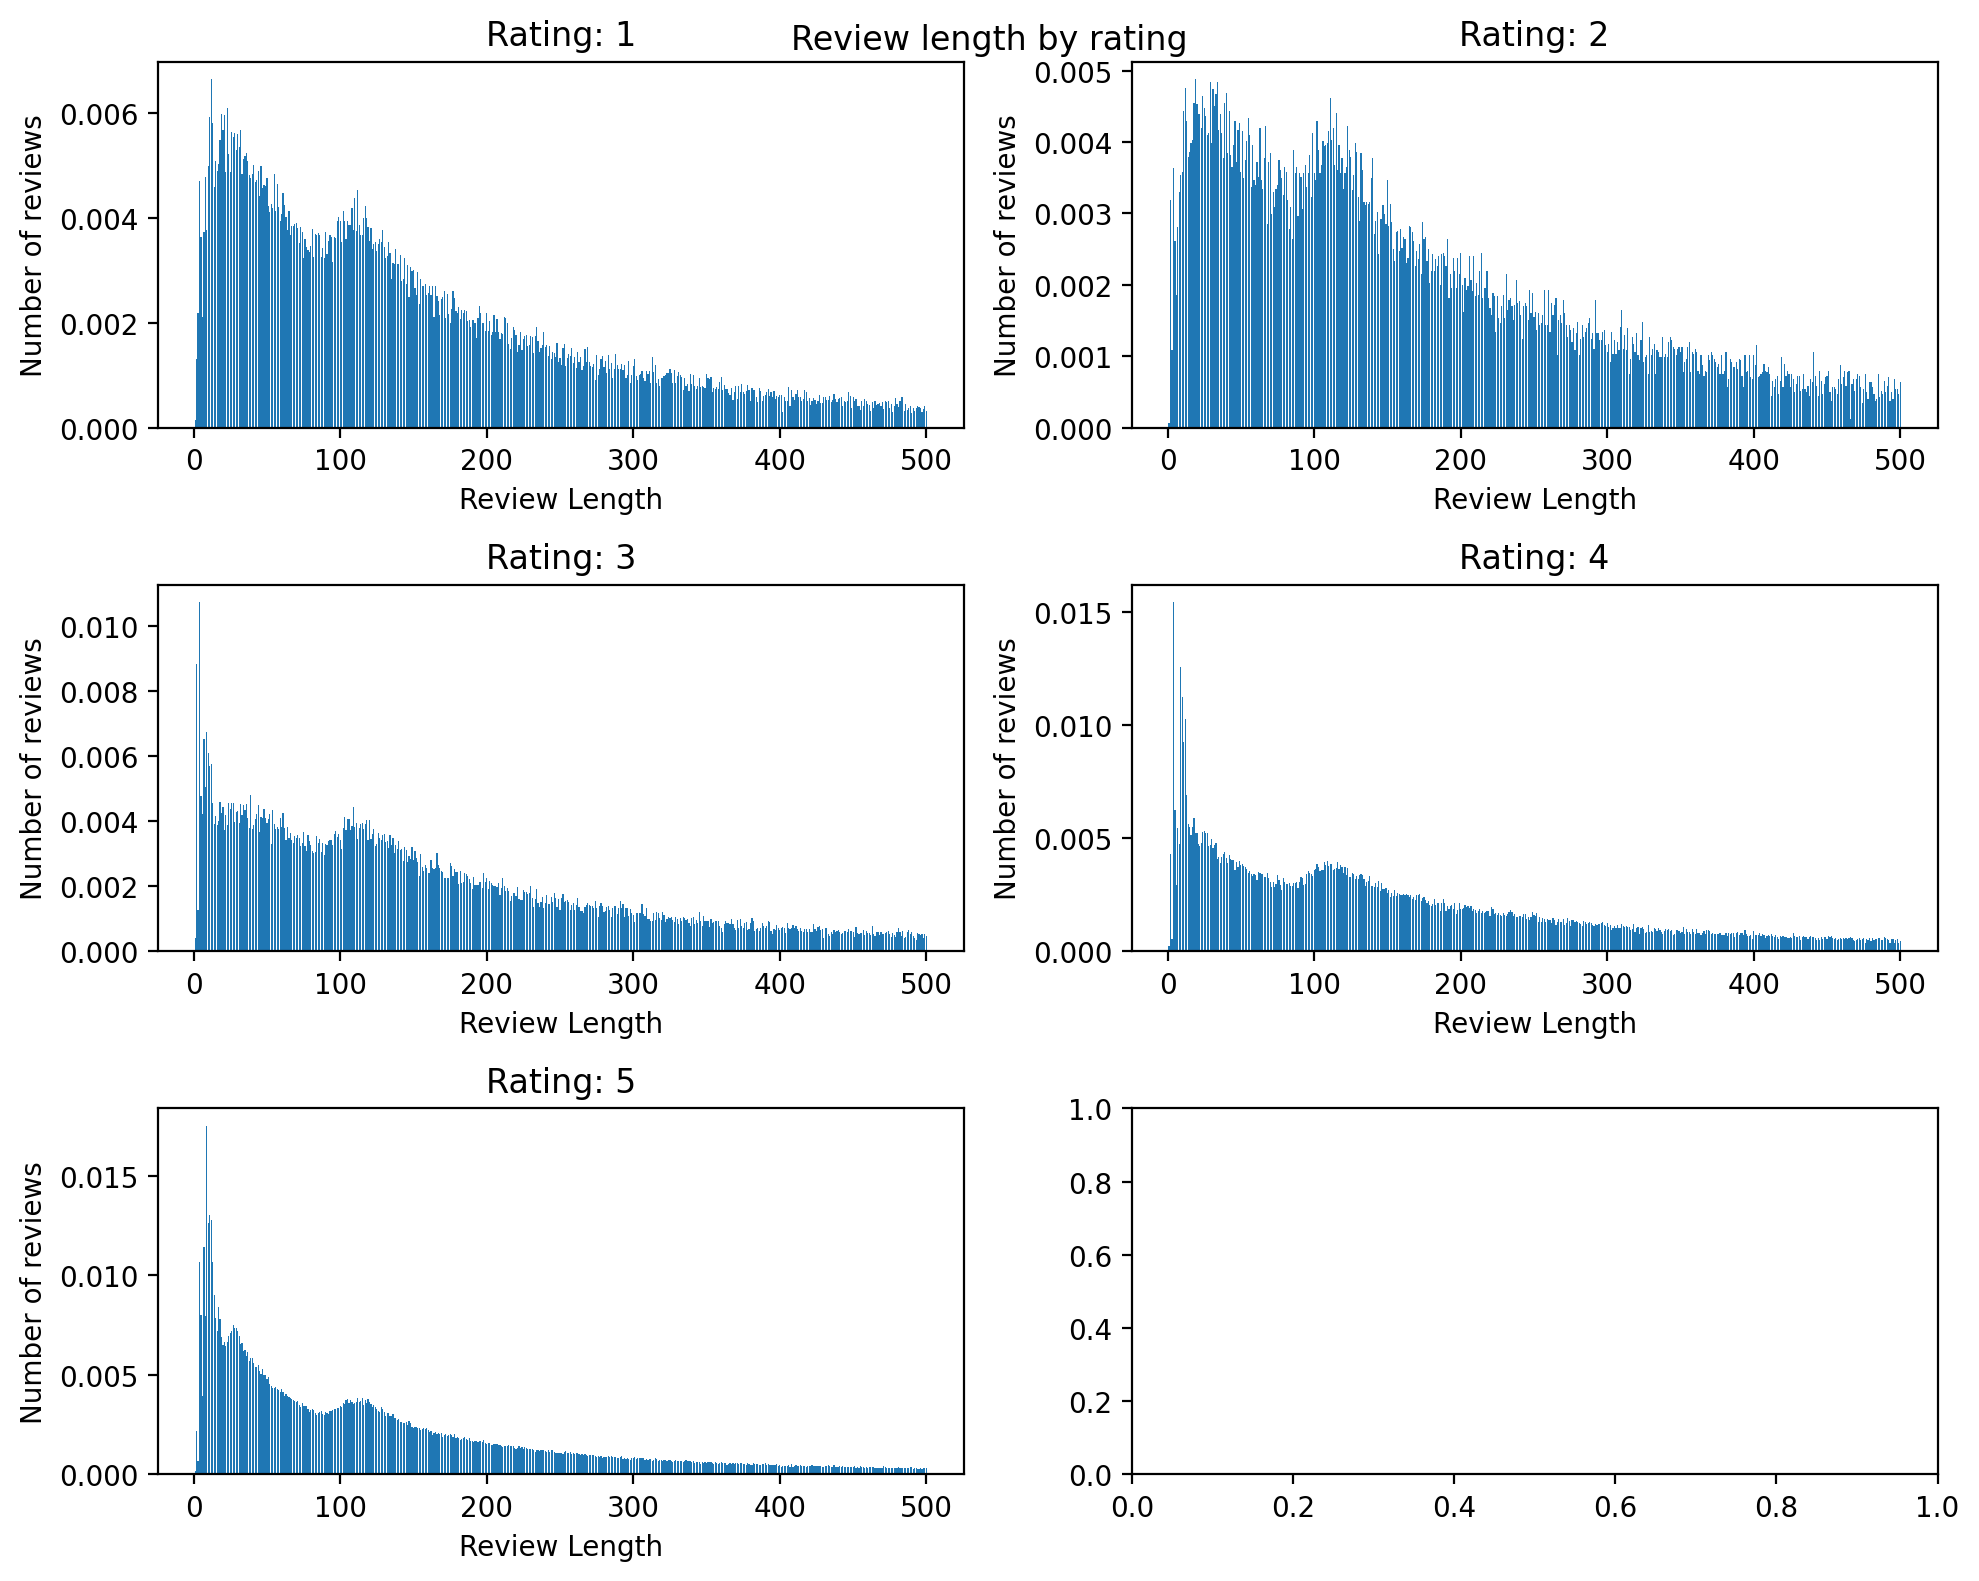

In [23]:
new = new_df[new_df["length"]<=500].copy()

plt.subplots(3,2, figsize=(10,8))
for i in range(1,6):
    len_dist = new["length"][new["overall"]==i].value_counts().reset_index()
    len_dist['count_norm']=len_dist['count']/len_dist["count"].sum()
    plt.subplot(3,2,i)
    # plt.bar(len_dist["length"],len_dist['count'])
    plt.bar(len_dist["length"],len_dist['count_norm'])
    plt.title(f"Rating: {i}")
    plt.xlabel("Review Length")
    plt.ylabel("Number of reviews")
plt.tight_layout()
plt.suptitle("Review length by rating")
plt.show()

Ignoring the outliers, the length of reviews seems to follow the same distribution overall regardless of rating. It is important to remember the vast majority of reviews are 5 stars, and we might need to eventually account for this bias in the data when modelling. As we can see, we have many more positive reviews than negative. 

In [24]:
l_values, l_counts = np.unique(new['length'], return_counts=True)
len_df = pd.DataFrame({
    'Review Length': l_values,
    'Number of Reviews': l_counts
})


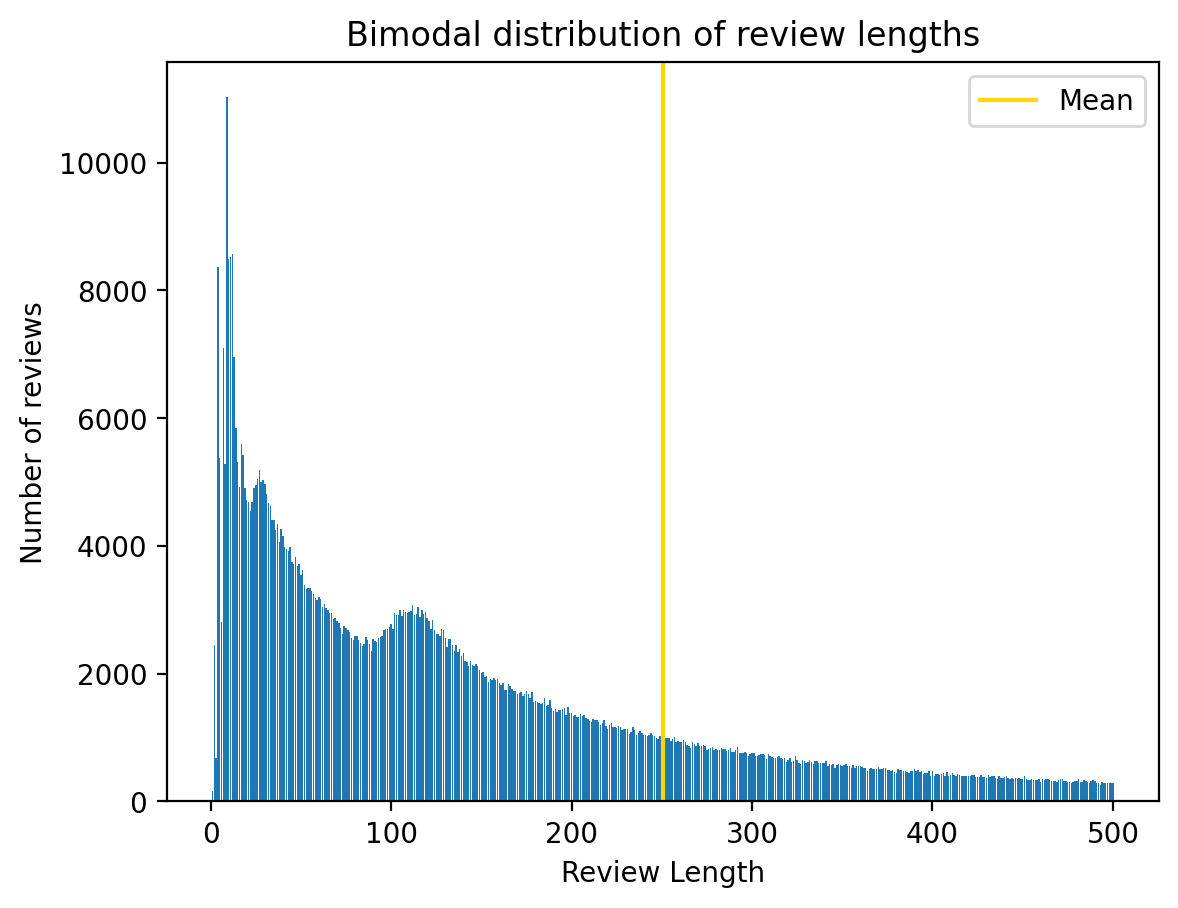

In [25]:
plt.figure()
plt.bar(l_values, l_counts)
plt.axvline(l_values.mean(), color='gold', label="Mean")

plt.xlabel("Review Length")
plt.ylabel("Number of reviews")
plt.title("Bimodal distribution of review lengths")
plt.legend()
plt.show()

In [26]:
asin_dict = dict(new['asin'].value_counts())

In [27]:
len(asin_dict)

47003

In [28]:
x_d = list(asin_dict.keys())
y_d = list(asin_dict.values())


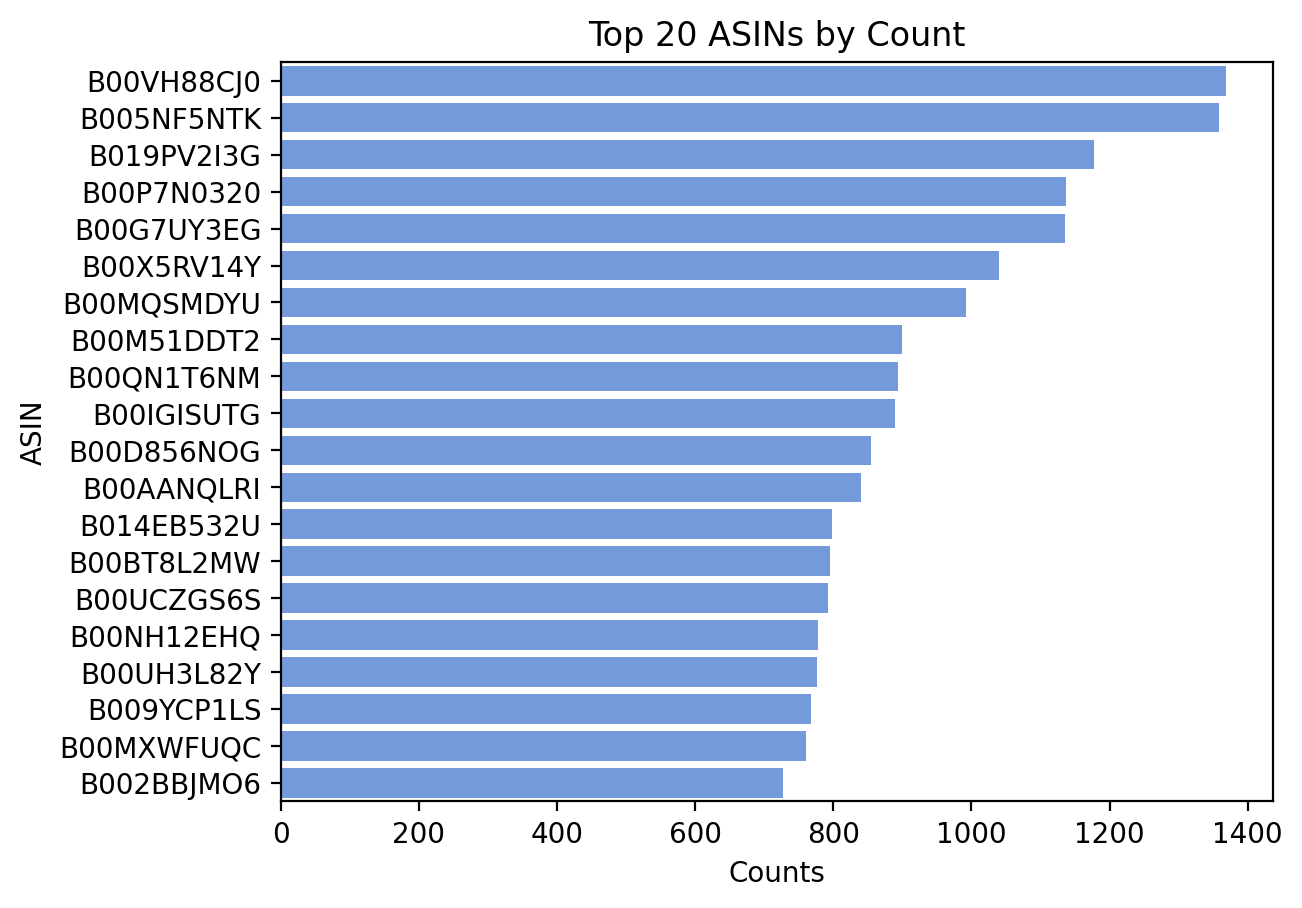

In [29]:
N = 20

# Select the top N ASINs
top_asins = dict(sorted(asin_dict.items(), key=lambda item: item[1], reverse=True)[:N])
x_top = list(top_asins.keys())
y_top = list(top_asins.values())

# plot
plt.figure()
sns.barplot(x=y_top, y=x_top, color="cornflowerblue")
plt.xlabel('Counts')
plt.ylabel('ASIN')
plt.title('Top 20 ASINs by Count')
plt.show()

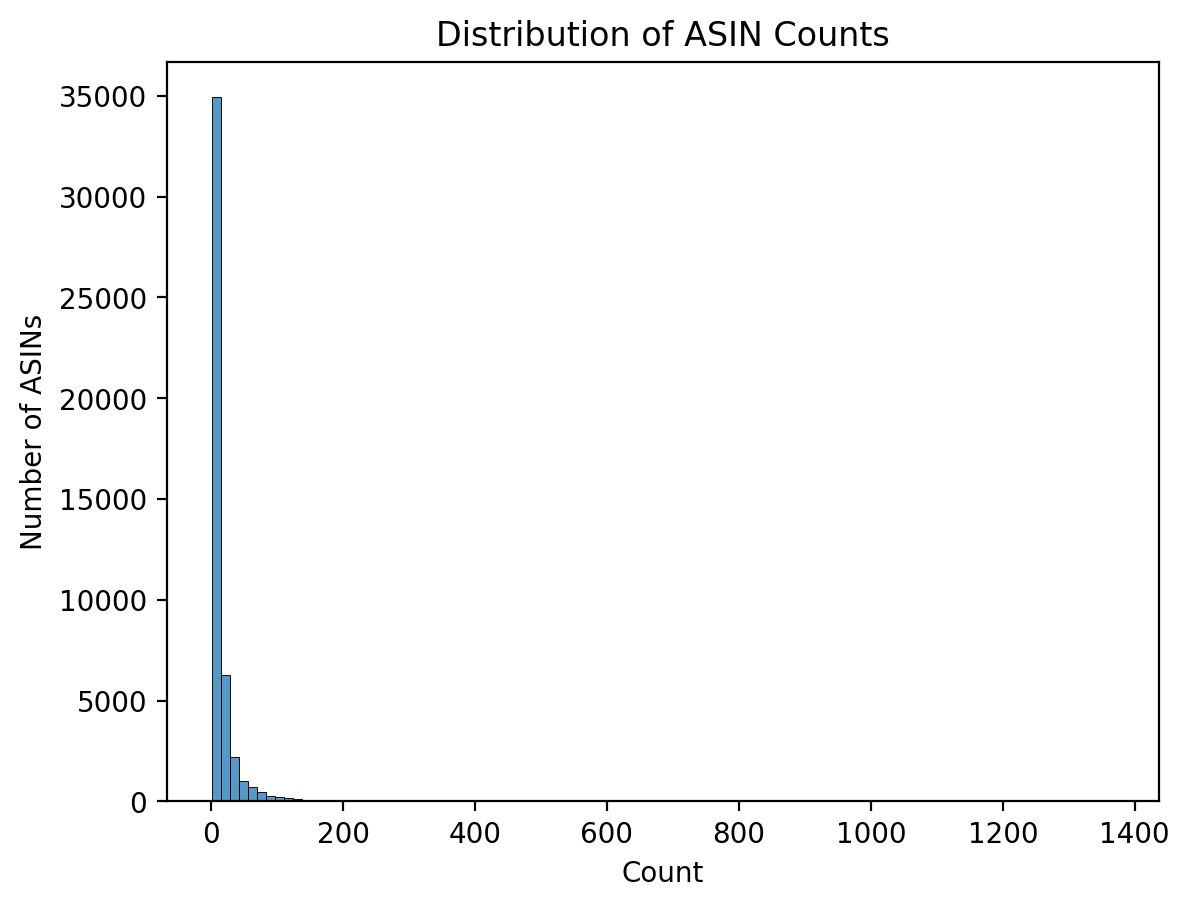

In [30]:
plt.figure()
sns.histplot(y_d, bins=100)  # Adjust the number of bins as needed
plt.xlabel('Count')
plt.ylabel('Number of ASINs')
plt.title('Distribution of ASIN Counts')
plt.show()

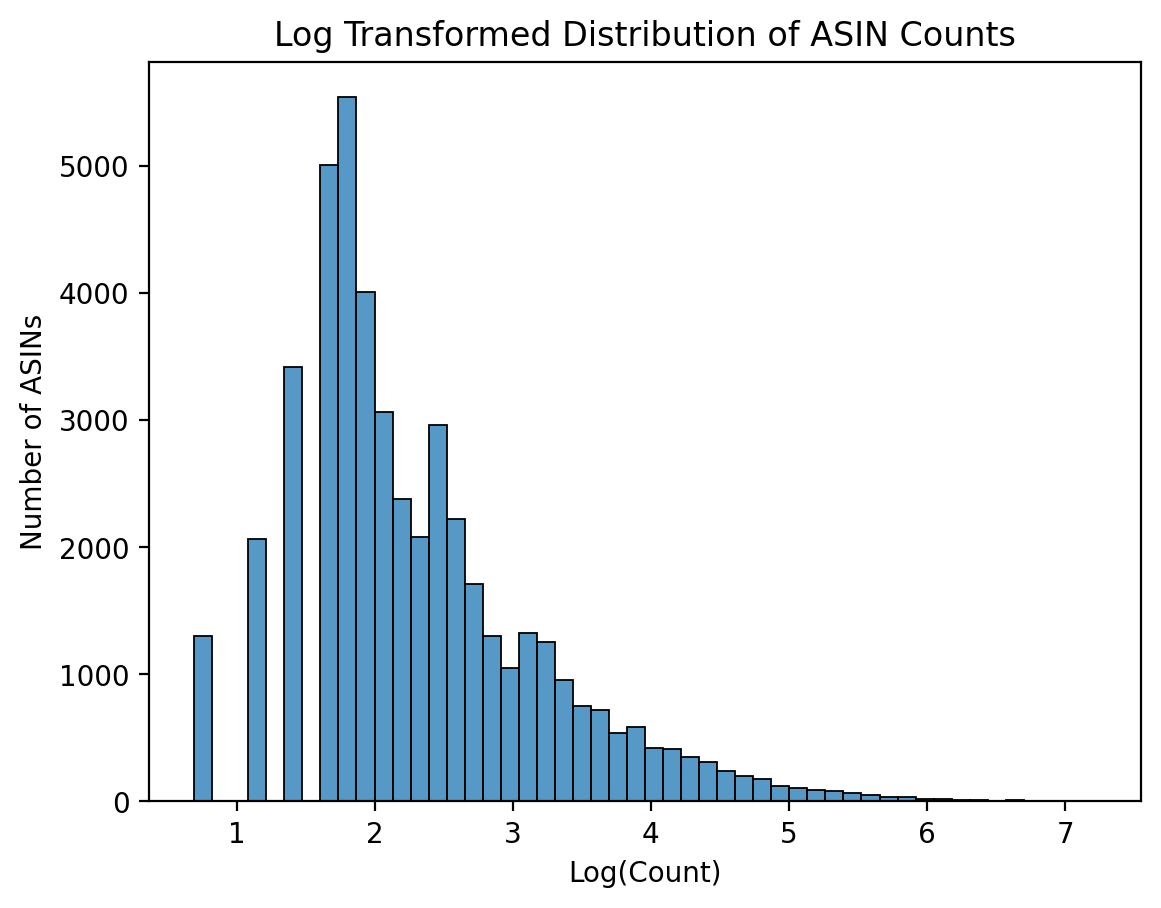

In [31]:
import numpy as np

# apply log transformation
y_log = np.log1p(y_d) #https://numpy.org/doc/stable/reference/generated/numpy.log1p.html

# plot8 8))
sns.histplot(y_log, bins=50)
plt.xlabel('Log(Count)')
plt.ylabel('Number of ASINs')
plt.title('Log Transformed Distribution of ASIN Counts')
plt.show()

In [32]:
pd.Series(asin_dict).describe()

count    47003.000000
mean        16.863200
std         38.758533
min          1.000000
25%          4.000000
50%          7.000000
75%         15.000000
max       1368.000000
dtype: float64

In [33]:
pd.Series(asin_dict).mode()

0    5
dtype: int64

We see that most products habe between 5 and 10 reviews, with just a few having hundecorals or even thousands. 

In [34]:
reviewer_ID_df = df["reviewerID"]
len(reviewer_ID_df.unique())

157212

In [35]:
reviewer_ID_df.value_counts().describe()

count    157212.000000
mean          6.496292
std           3.961897
min           1.000000
25%           5.000000
50%           6.000000
75%           7.000000
max         330.000000
Name: count, dtype: float64

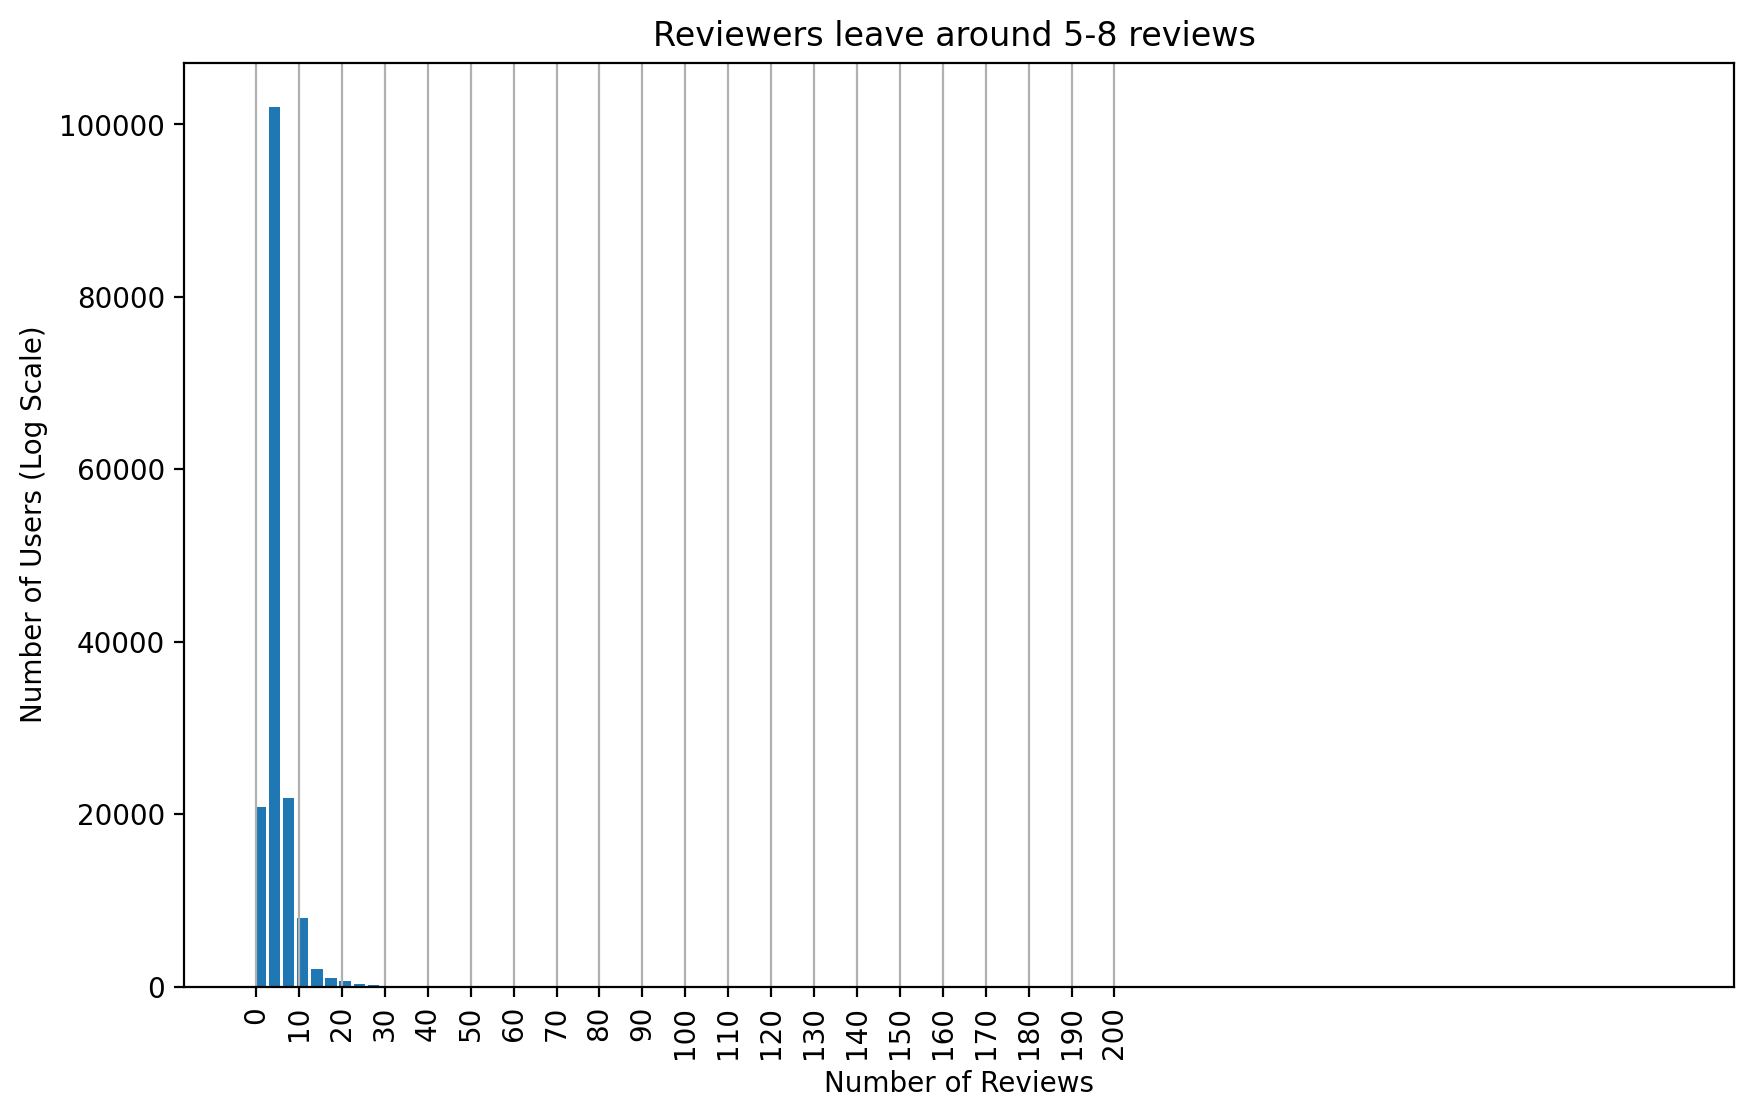

In [36]:
review_count = df['reviewerID'].value_counts()

# Plot a histogram with a logarithmic y-axis
plt.figure(figsize=(10, 6))
review_count.hist(bins=100, align='left', rwidth=0.8)

plt.title('Reviewers leave around 5-8 reviews ')
plt.xlabel('Number of Reviews')
plt.ylabel('Number of Users (Log Scale)')
plt.xticks([x for x in range(0,201,10)], rotation=90)
plt.grid(axis='y')
plt.show()

Most reviwers leave between 5-10 reviews, with very few above that. We should not expect to see one users language dominating the reviews. However it could be worth in the future thinking about whether there are users swaying the model?

## Term Frequency analysis
I will import the document term table from the "03-preprocessing.ipynb" notebook. The reviews were vectorised using TD-IDF,with `min_df=10` and a custom tokeniser (found in "source.py"). There are 500 1-grams and 100 additional 2-grams.

In [37]:
count = CountVectorizer(max_features=600, min_df=10, tokenizer=my_tokenizer)
count.fit(new_df["reviewText"])

/Users/edo/anaconda3/envs/es_capstone/lib/python3.8/site-packages/sklearn/feature_extraction/text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


CountVectorizer(max_features=600, min_df=10,
                tokenizer=<function my_tokenizer at 0x1698ca550>)

In [38]:
pos = new_df[(new_df["overall"]==4.0)|(new_df["overall"]==5.0)]

In [39]:
neg = new_df[(new_df["overall"]!=4.0)|(new_df["overall"]!=5.0)]

In [41]:
count_pos = CountVectorizer(max_features=600, min_df=10, tokenizer=my_tokenizer)
count_neg = CountVectorizer(max_features=600, min_df=10, tokenizer=my_tokenizer)

In [42]:
count_pos.fit(pos["reviewText"])

CountVectorizer(max_features=600, min_df=10,
                tokenizer=<function my_tokenizer at 0x1698ca550>)

In [43]:
count_neg.fit(neg["reviewText"])

CountVectorizer(max_features=600, min_df=10,
                tokenizer=<function my_tokenizer at 0x1698ca550>)

In [45]:
pos_transformed = count_pos.transform(pos["reviewText"].fillna(''))


In [46]:
neg_transformed = count_neg.transform(neg["reviewText"].fillna(''))


In [47]:
word_counts_neg = pd.DataFrame(
    {"counts": neg_transformed.toarray().sum(axis=0)},
    index=count_neg.get_feature_names_out()
).sort_values(by="counts", ascending=False)

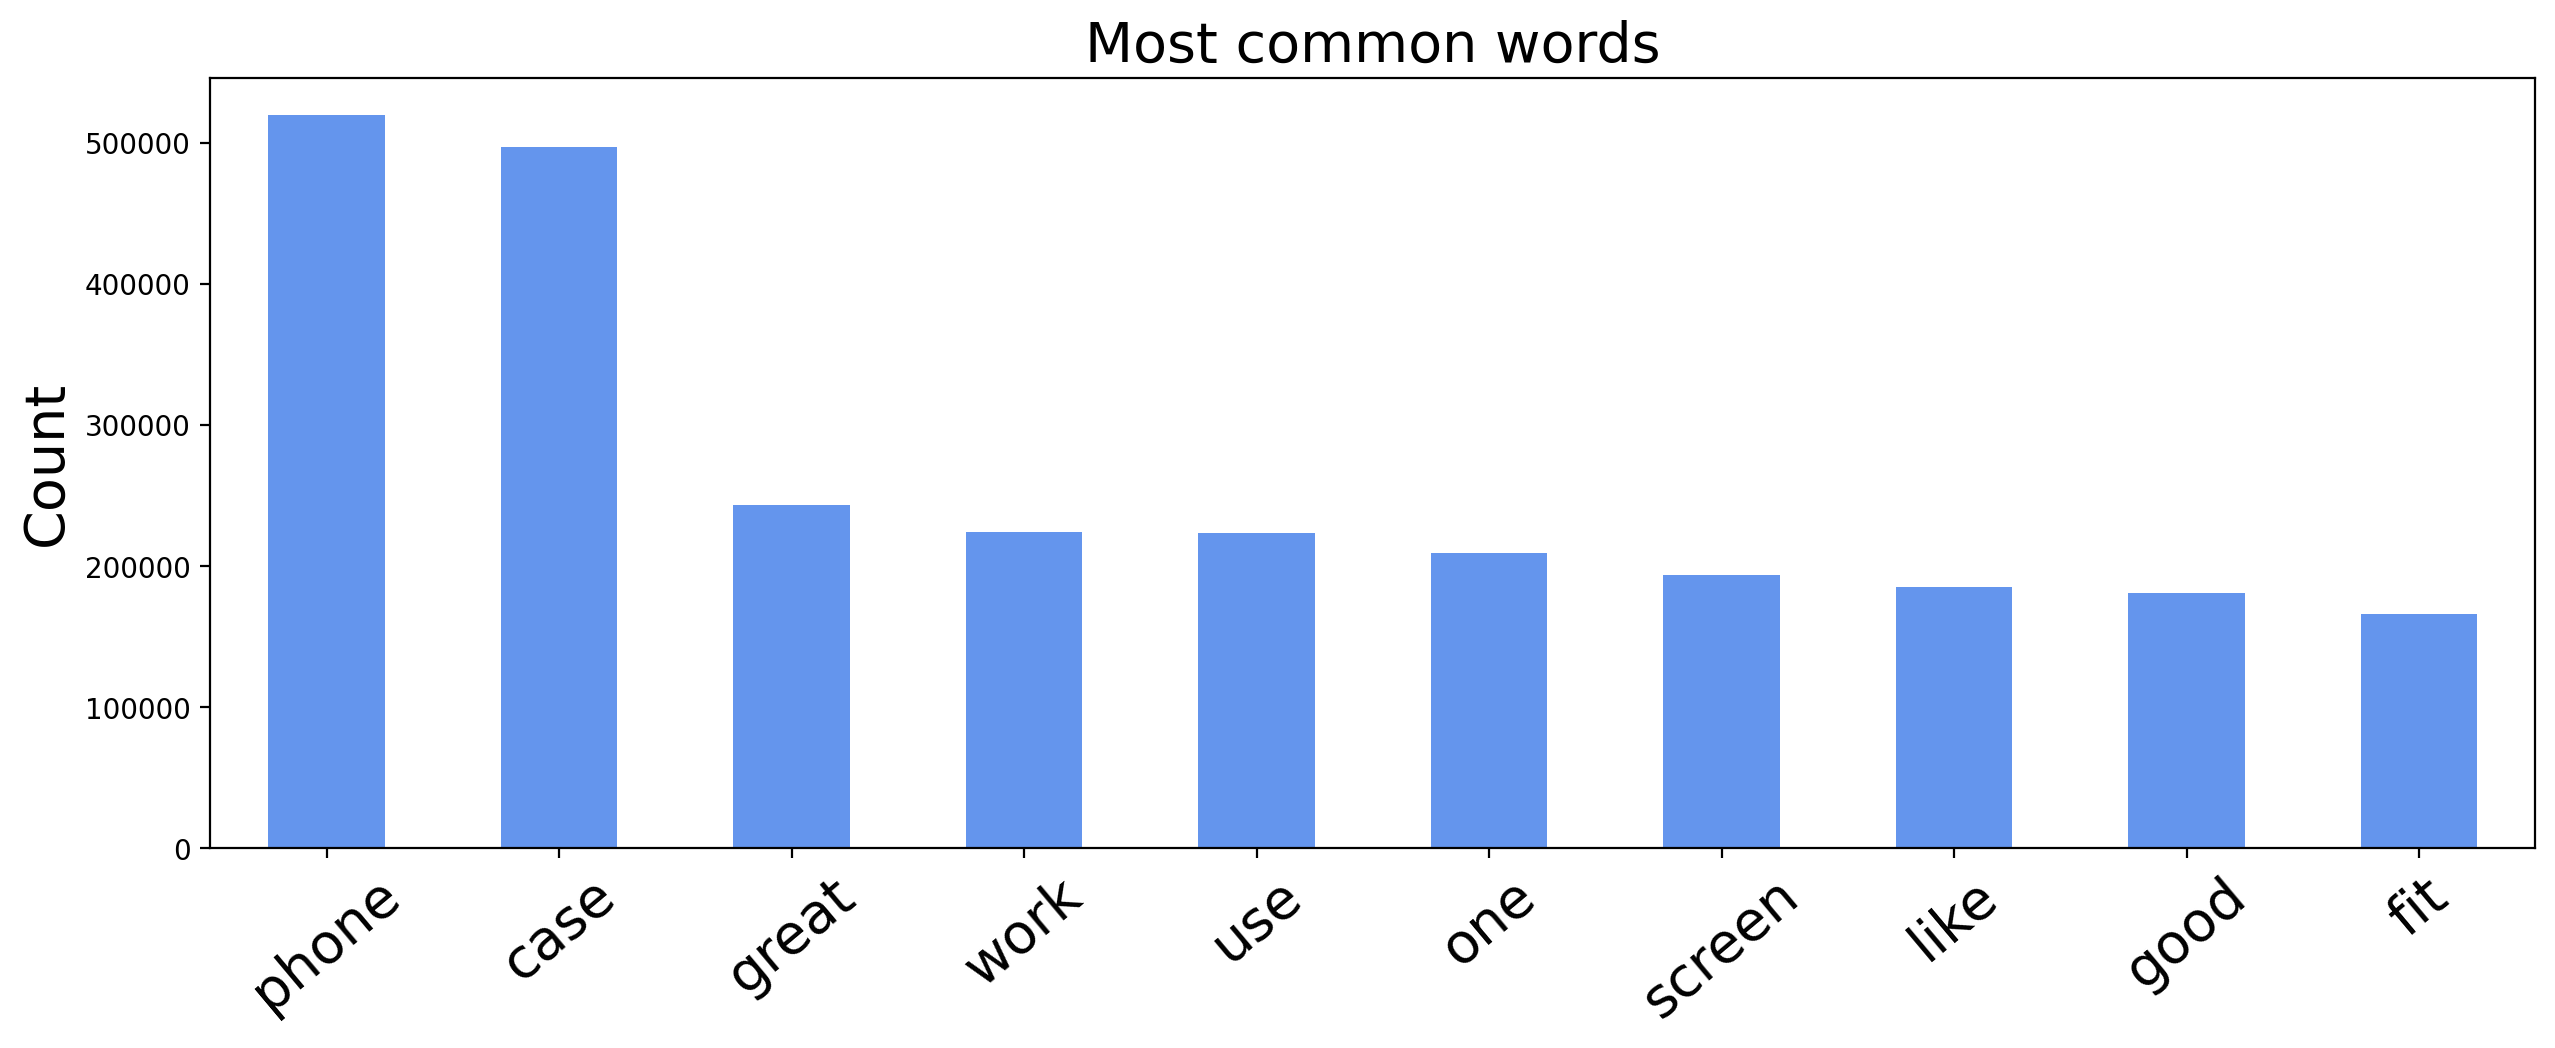

In [74]:
word_counts.sort_values(by="counts", ascending=False).head(10).plot(kind="bar", figsize=(15, 5), legend=False, color="cornflowerblue")
plt.title("Most common words", fontsize=20)
plt.ylabel("Count", fontsize=20)
plt.xticks(rotation=40, fontsize=20)
plt.show()

In [49]:
word_counts_pos = pd.DataFrame(
    {"counts": pos_transformed.toarray().sum(axis=0)},
    index=count_pos.get_feature_names_out()
).sort_values(by="counts", ascending=False)

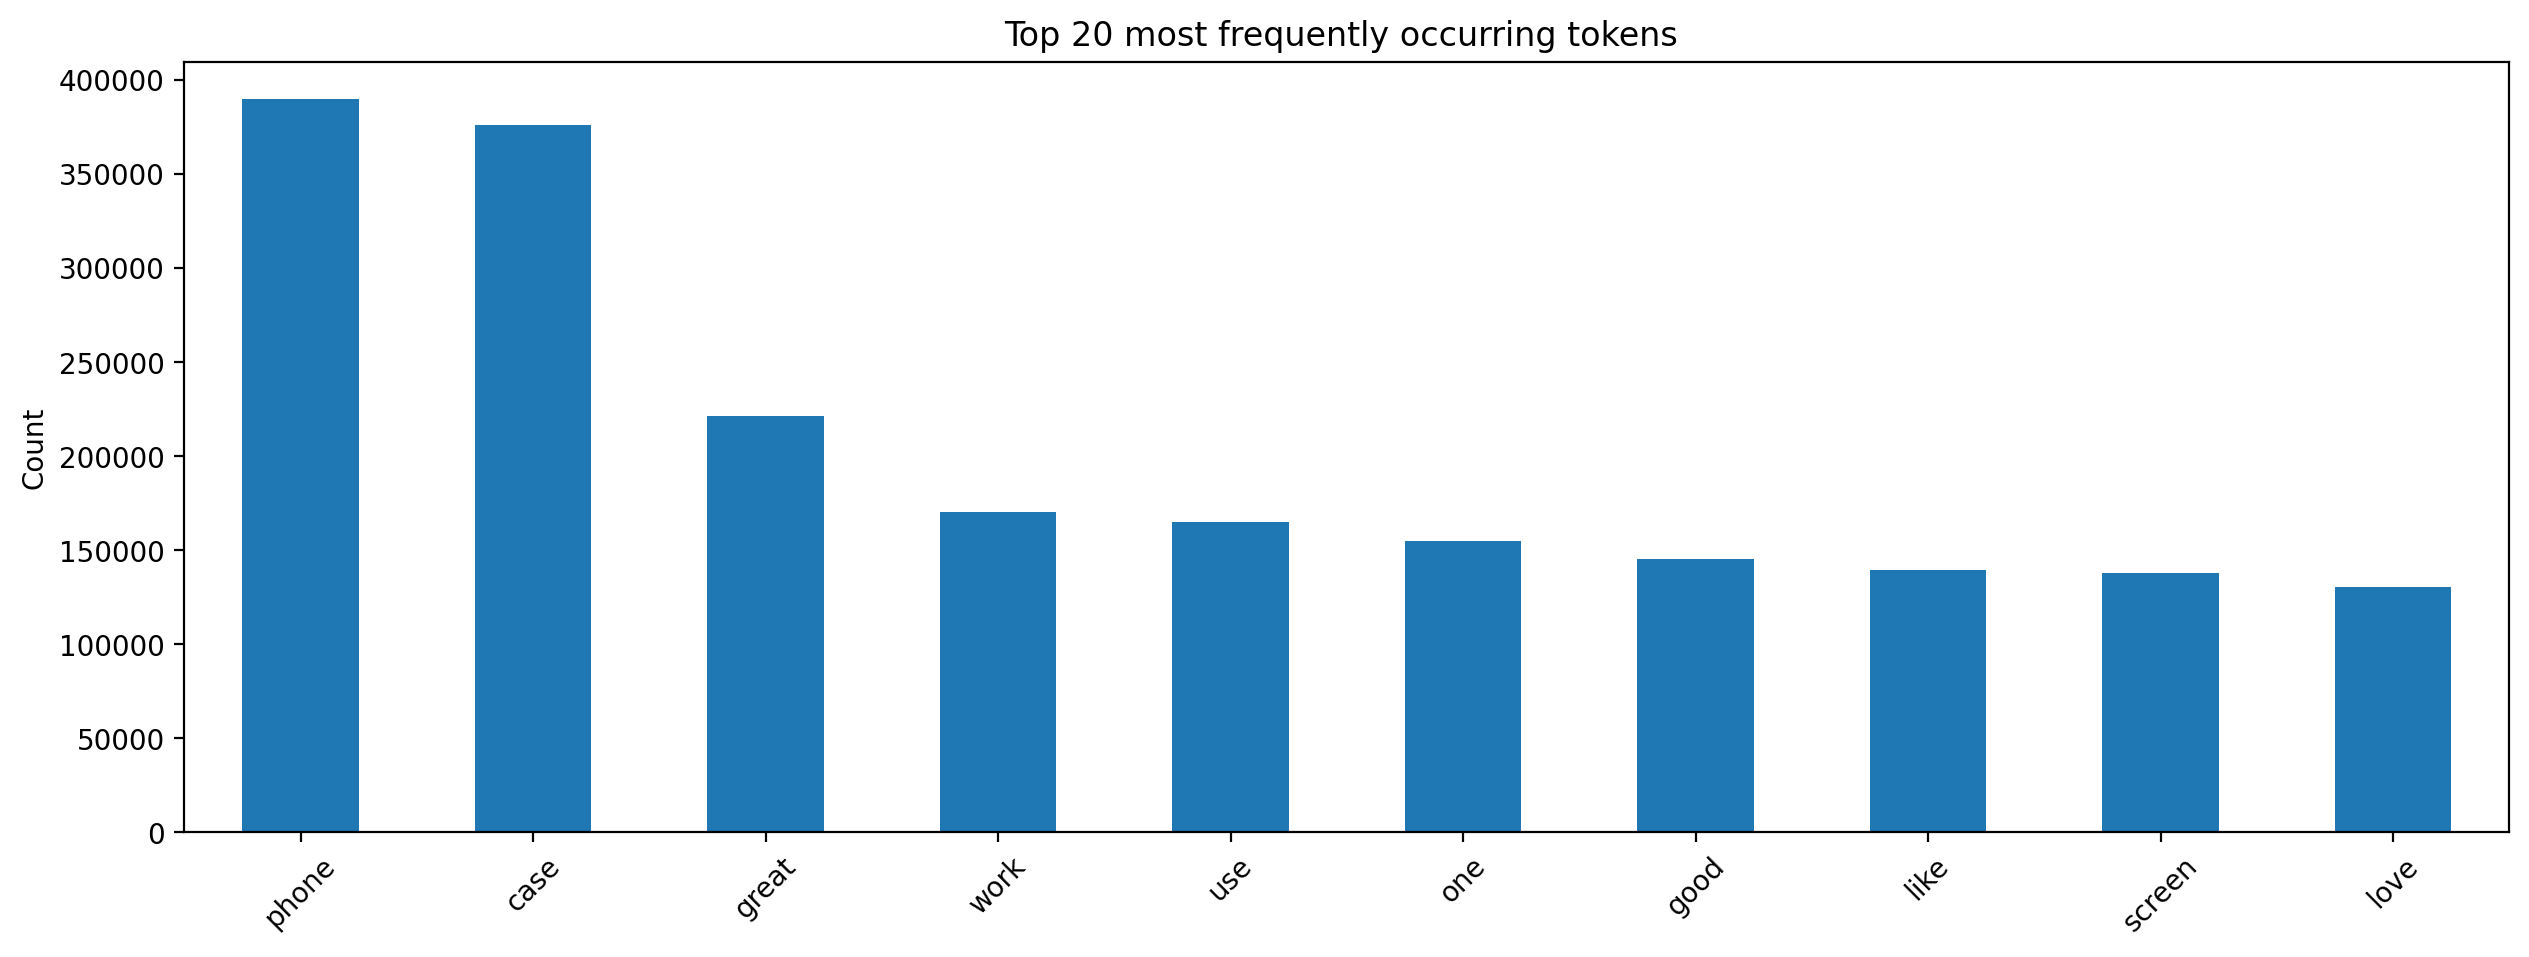

In [64]:
word_counts_pos.head(10).plot(kind="bar", figsize=(15, 5), legend=False)
plt.title("Top 20 most frequently occurring tokens ")
plt.ylabel("Count")
plt.xticks(rotation=45)
plt.show()

In [115]:
# load in the pickle file
doc_term = joblib.load("../data/total_word_freq.pkl")

In [67]:
reviews_transformed = count.transform(new_df["reviewText"].fillna(''))


In [69]:
reviews_transformed

<886240x600 sparse matrix of type '<class 'numpy.int64'>'
	with 12006850 stored elements in Compressed Sparse Row format>

In [70]:
word_counts = pd.DataFrame(
    {"counts": reviews_transformed.toarray().sum(axis=0)},
    index=count.get_feature_names_out()
)

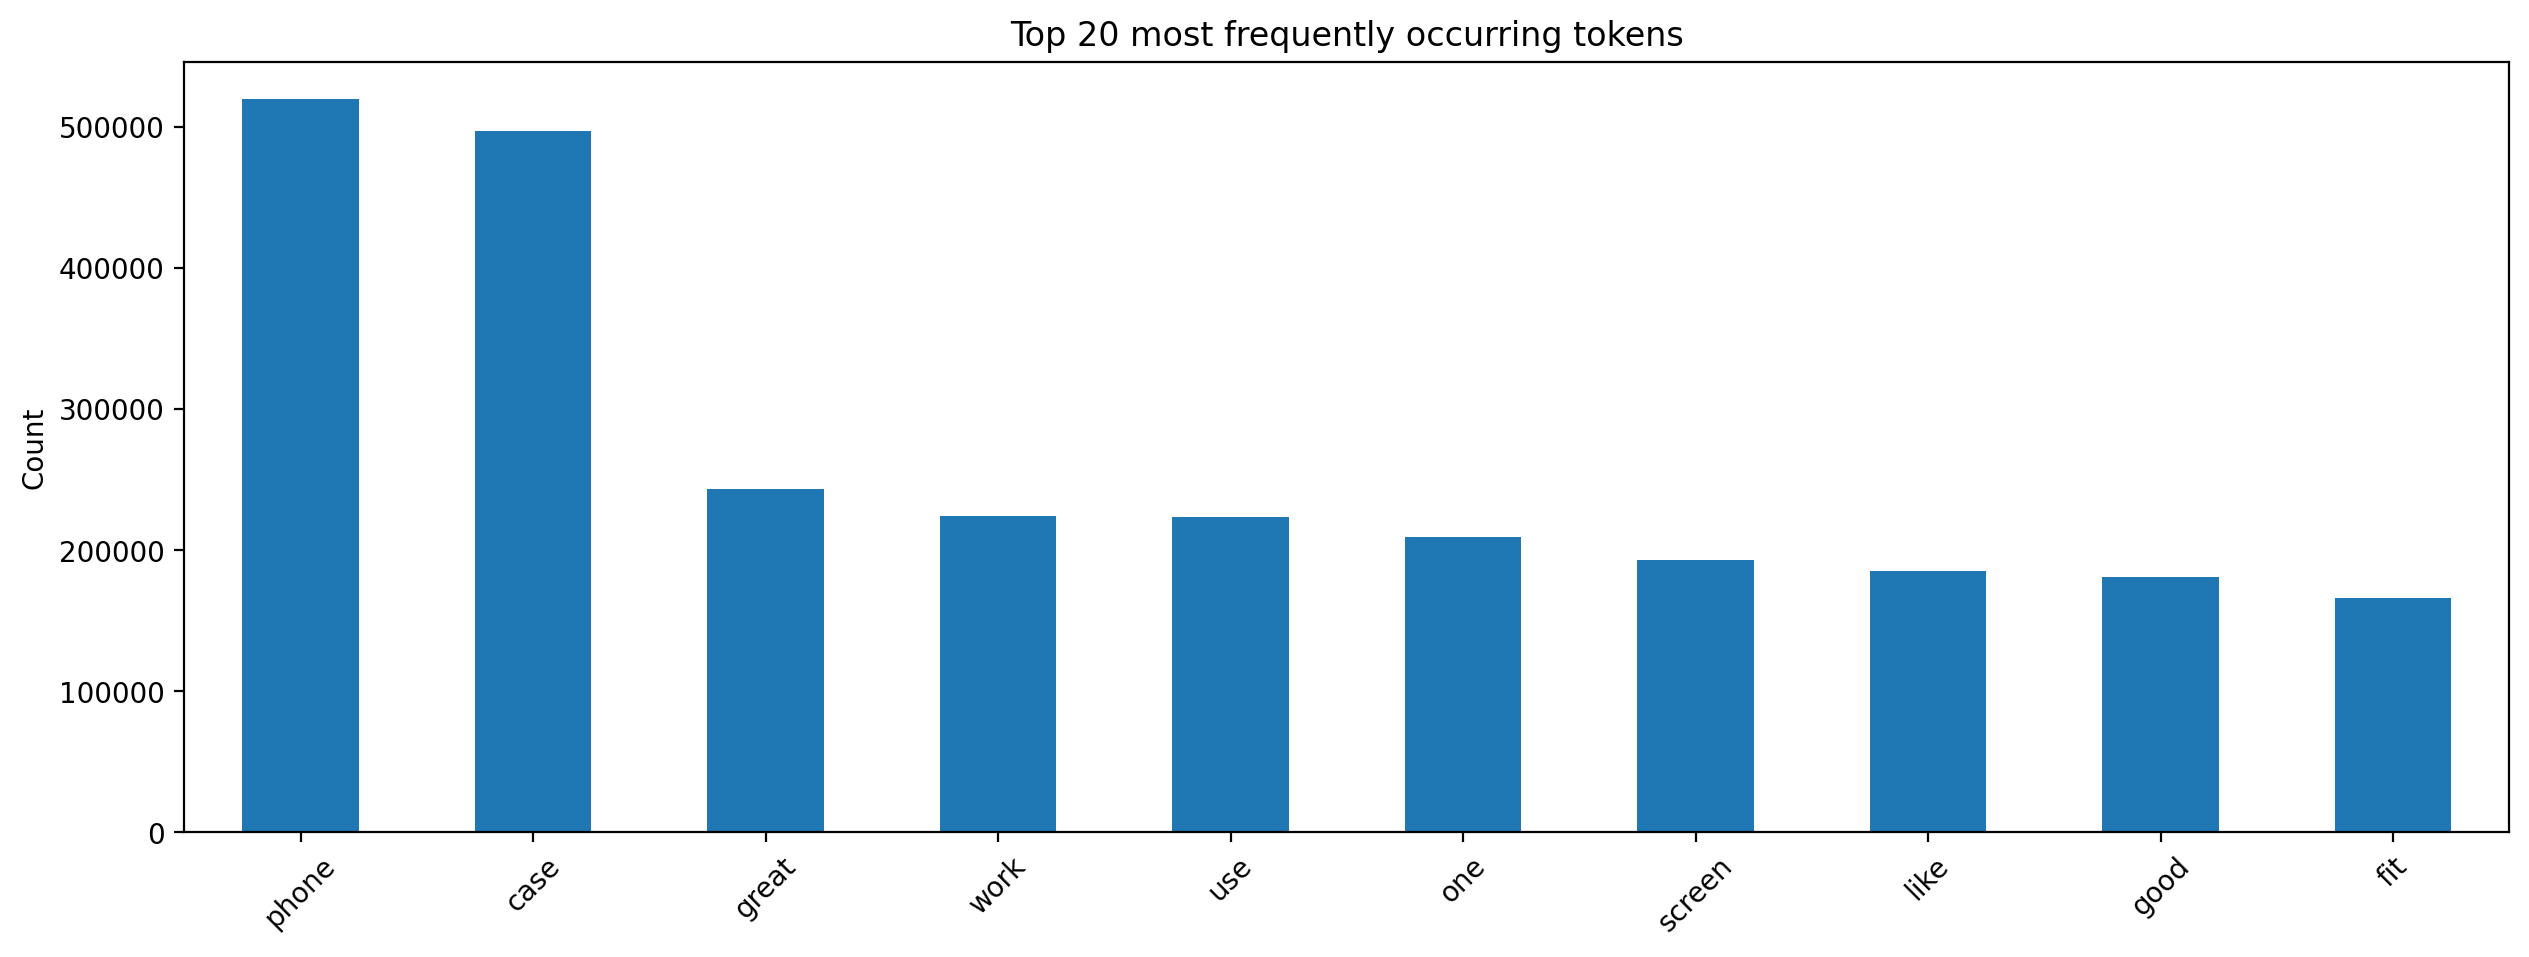

In [71]:
word_counts.sort_values(by="counts", ascending=False).head(10).plot(kind="bar", figsize=(15, 5), legend=False)
plt.title("Top 20 most frequently occurring tokens")
plt.ylabel("Count")
plt.xticks(rotation=45)
plt.show()

In [131]:
review_vectors_df = pd.DataFrame(reviews_transformed.toarray(), columns=count.get_feature_names_out())

In [133]:
output_df_1_2 = pd.concat([new_df, review_vectors_df], axis=1)

In [145]:
pos = output_df_1_2[(output_df_1_2["overall"]==4.0)|(output_df_1_2["overall"]==5.0)]

In [146]:
neg = output_df_1_2[(output_df_1_2["overall"]!=4.0)|(output_df_1_2["overall"]!=5.0)]

In [149]:
pos

,overall,reviewText,asin,length,10,100,20,30,6s,abl,...,work,worri,worth,would,wouldnt,wrong,ye,year,yet,your
0,5.0,Looks even better in person. Be careful to not...,7508492919,271,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,5.0,When you don't want to spend a whole lot of ca...,7508492919,102,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,4.0,"I liked it because it was cute, but the studs ...",7508492919,150,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
7,5.0,It is a very cute case. None of the jewels hav...,7508492919,327,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
9,4.0,I really love this case... you have to keep yo...,7508492919,188,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
886232,5.0,This screen protector was very easy to apply. ...,B01HISNNXC,75,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
886234,5.0,Wouldn't be able to live without it. Strong ma...,B01HIRQLNW,73,0,0,0,0,0,1,...,0,0,0,0,1,0,0,0,0,0
886235,4.0,Very good cell phone holster. Keeps my phone ...,B01HJBS5C2,79,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
886238,4.0,Good for viewing. But doesn't have a button or...,B01HJC7N4C,142,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [150]:
word_counts = pd.DataFrame(
    {"counts": pos[4:].sum(axis=0)},
    index=pos["10":].index
)

In [140]:
output_df_1_2.head()

,overall,reviewText,asin,length,10,100,20,30,6s,abl,...,work,worri,worth,would,wouldnt,wrong,ye,year,yet,your
0,5.0,Looks even better in person. Be careful to not...,7508492919,271,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,5.0,When you don't want to spend a whole lot of ca...,7508492919,102,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,3.0,"so the case came on time, i love the design. I...",7508492919,257,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
3,2.0,DON'T CARE FOR IT. GAVE IT AS A GIFT AND THEY...,7508492919,92,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,4.0,"I liked it because it was cute, but the studs ...",7508492919,150,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0


In [65]:
doc_term

,counts
1gram__case,27399.604047
1gram__phone,26206.007861
1gram__great,23773.110671
1gram__work,20541.131640
1gram__good,18034.195232
...,...
1gram__happen,722.489443
1gram__vent,714.526076
1gram__point,708.688355
1gram__contact,690.402654


In [66]:
# make sure that is is sorted
doc_term = doc_term.sort_values(by="counts", ascending=False)

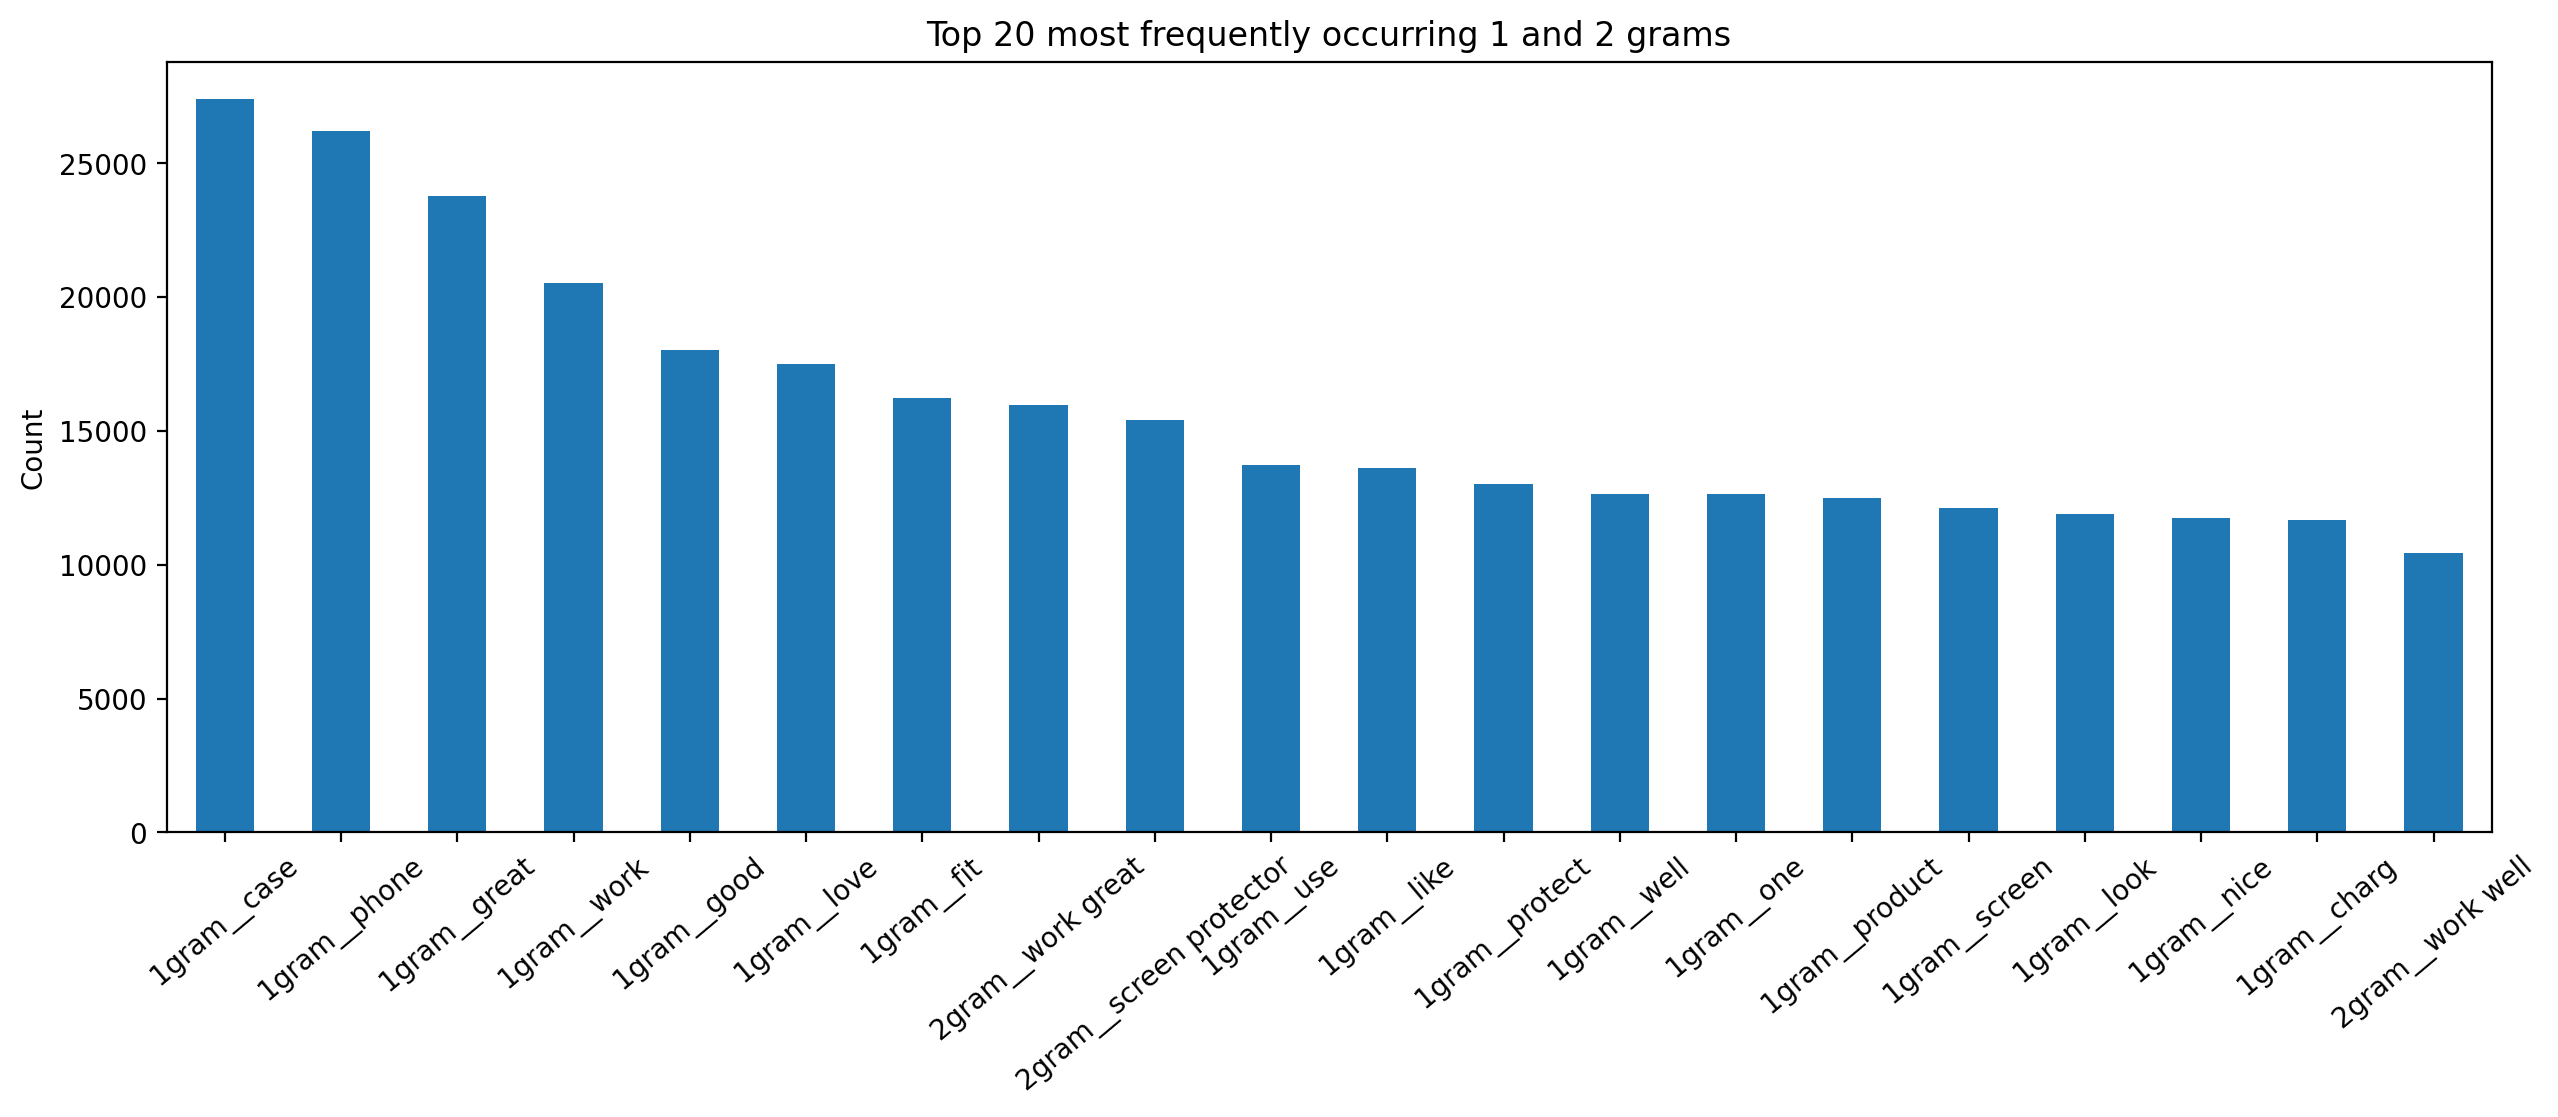

In [67]:
doc_term.head(20).plot(kind="bar", figsize=(15, 5), legend=False)
plt.title("Top 20 most frequently occurring 1 and 2 grams")
plt.ylabel("Count")
plt.xticks(rotation=40)
plt.show()

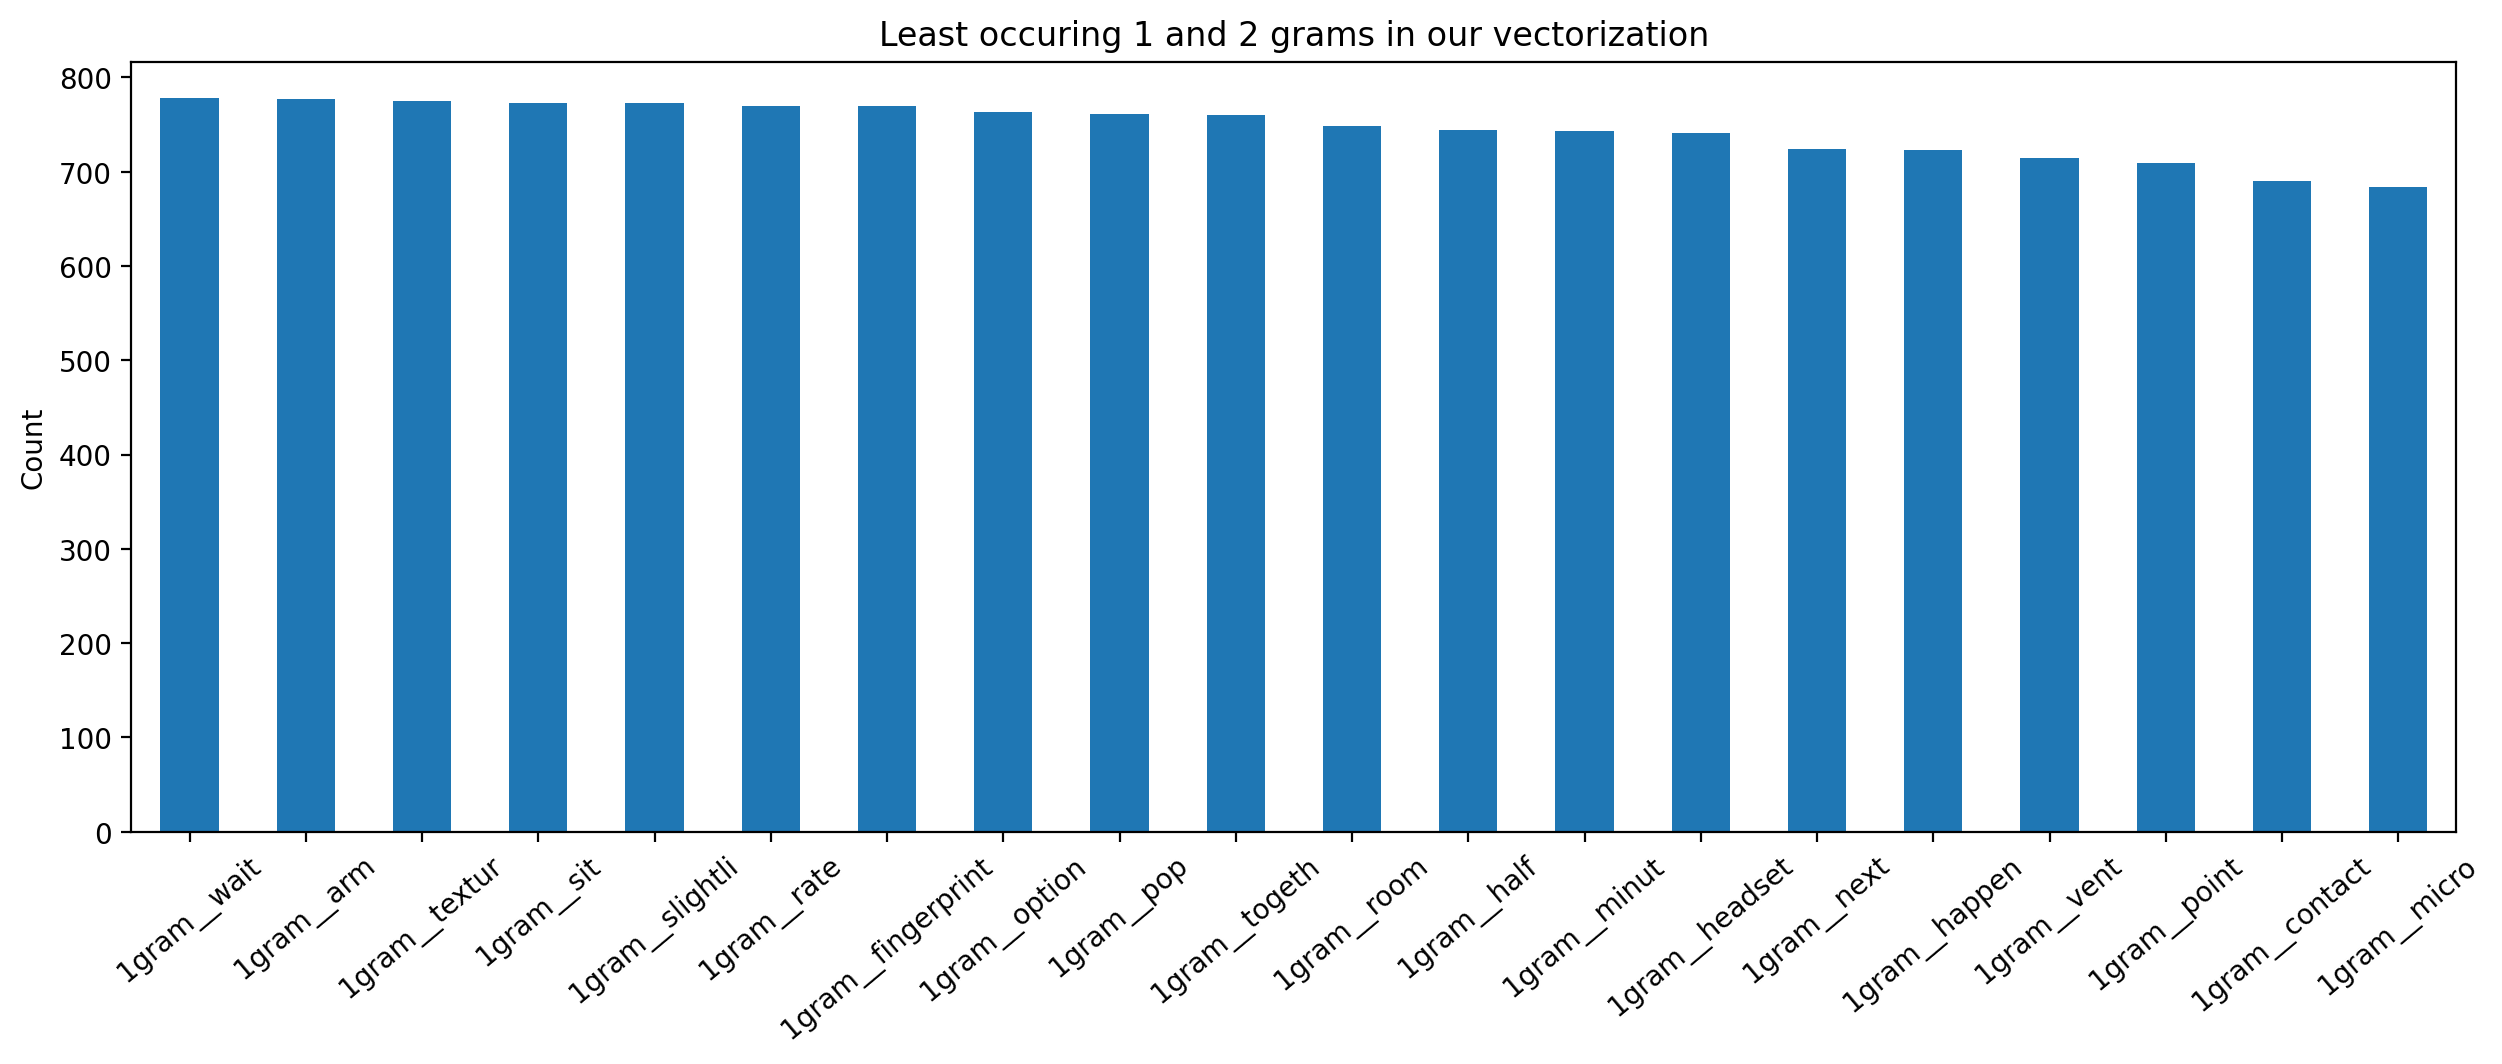

In [68]:
doc_term.tail(20).plot(kind="bar", figsize=(15, 5), legend=False)
plt.title("Least occuring 1 and 2 grams in our vectorization")
plt.ylabel("Count")
plt.xticks(rotation=40)
plt.show()